In [1]:
%matplotlib ipympl
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.special import erf

from IPython.display import HTML

/home/tomasz/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def random_walk(num_steps, std_dev, start = "center"):
    if start == "center": start_pos = np.ones(3)*0.5
    elif start == "random": start_pos = np.random.random(3)
    steps = np.random.normal(0.0, std_dev, size=(num_steps, 3))
    walk = start_pos + np.cumsum(steps, axis=0)
    for frame in walk:
        for i in range(3):
            while frame[i] > 1.0:
                frame[i] -= 1.0
            while frame[i] < 0.0:
                frame[i] += 1.0
    return walk

def update_lines(num, walks, lines, ax):
    for line, walk in zip(lines, walks):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(walk[num-1:num, :2].T)
        line.set_3d_properties(walk[num-1:num, 2])
        ax.set_title('Time={}'.format(num))
    return lines

def perform_bd(num_steps, std_dev, start, num_particles):
    return [random_walk(num_steps, std_dev, start) for index in range(num_particles)]

def vis(walks):

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    
    num_steps = np.shape(walks)[1]

    lines = [ax.plot([], [], [], 'o')[0] for _ in walks]

    ax.set(xlim3d=(0, 1), xlabel='X')
    ax.set(ylim3d=(0, 1), ylabel='Y')
    ax.set(zlim3d=(0, 1), zlabel='Z')

    ani = animation.FuncAnimation(
        fig, update_lines, num_steps, fargs=(walks, lines, ax), interval=100)

#     ani.save('test.mp4')
#     plt.show()
    html = HTML(ani.to_jshtml())
    display(html)

def count_in_subbox(traj, subbox):
    num_steps = np.shape(traj)[1]
    num_particles = np.shape(traj)[0]
    count = np.zeros(num_steps, dtype = int)
    for j in range(num_steps):
        for k in range(num_particles):
            if traj[k][j][0] >= subbox[0][0] and traj[k][j][0] <= subbox[0][1]:
                if traj[k][j][1] >= subbox[1][0] and traj[k][j][1] <= subbox[1][1]:
                    if traj[k][j][2] >= subbox[2][0] and traj[k][j][2] <= subbox[2][1]:
                        count[j] += 1
                    else:
                        continue
                else:
                    continue
            else:
                continue
    return count

def vis_subbox(subbox_definition, particle_count, num_particles):
    fig, ax = plt.subplots()
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches( (DefaultSize[0], DefaultSize[1]) )

    nx=2
    ny=2
    grid = plt.GridSpec(nrows=ny, ncols=nx, wspace=0.5, hspace=0.7)

    axa = plt.subplot(grid[0, 0], projection="3d")
    axb = plt.subplot(grid[0, 1])
    axc = plt.subplot(grid[1, 0])
    axd = plt.subplot(grid[1, 1])
    axc.axis('off')
    axd.axis('off')

    vertices = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1],
    [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]], dtype=int)
    vertices = np.array(subbox_definition)[np.arange(3)[np.newaxis, :].repeat(8, axis=0), vertices]

    edges = np.array([[0, 1], [0, 2], [0, 4], [1, 3], [1, 5], [2, 3], [2, 6],
    [3, 7], [4, 5], [4, 6], [5, 7], [6, 7]], dtype=int)

    _ = axa.set_xlim((0,1))
    _ = axa.set_ylim((0,1))
    _ = axa.set_zlim((0,1))
    _ = axa.set_xlabel('X')
    _ = axa.set_ylabel('Y')
    _ = axa.set_zlabel('Z')
#     _ = axa.plot(*vertices.T, 'o', color = 'red')
    for i, j in edges:
        _ = axa.plot(*vertices[[i, j], :].T, color='r', ls='-')
    
    _ = axb.set_ylim((-1, num_particles+10))
    _ = axb.set_xlabel('Time')
    _ = axb.set_ylabel('Particle count')
    _ = axb.plot(particle_count)

# Task 1
Assume an infinite space, with a bolus of particles dropped in the middle at time zero. (use an artificially slow diffusion coefficient) Calculate the concentration of particles in a few points in space for a few points in time.

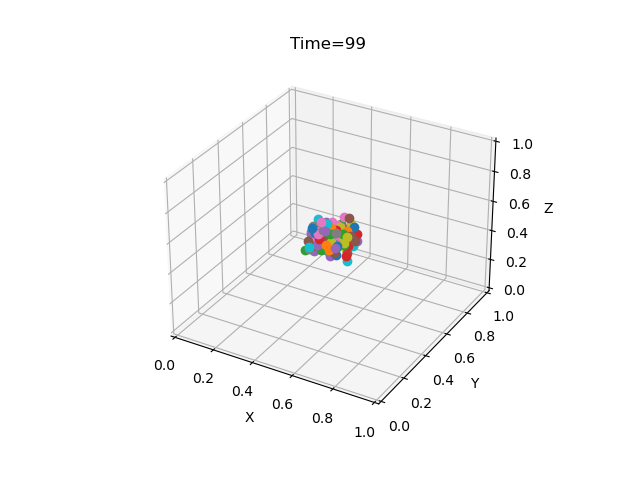

In [6]:
plt.close()
np.random.seed(19680801)
num_particles = 200
num_steps = 10000
std_dev = 0.0005
traj = perform_bd(num_steps=num_steps, std_dev=std_dev, start="center", num_particles=num_particles)
vis(np.array(traj)[:,::100,:])

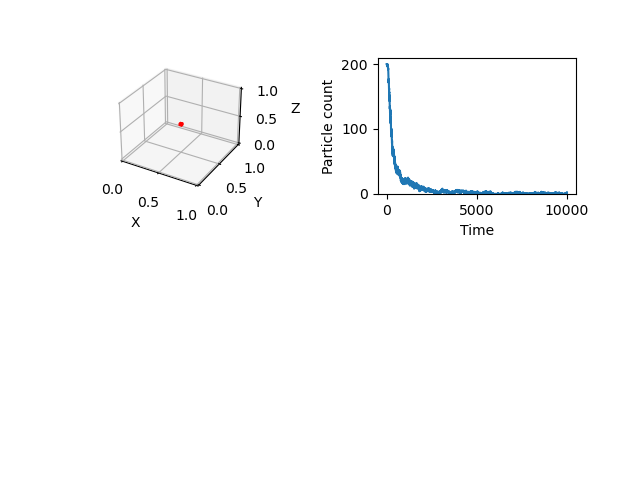

In [7]:
plt.close()
# subbox_definition = [[0.49, 0.51], [0.49, 0.51], [0.49, 0.51]]
subbox_definition = [[0.49, 0.51], [0.49, 0.51], [0.49, 0.51]]
subbox = np.array(subbox_definition)
count = count_in_subbox(traj, subbox)
vis_subbox(subbox_definition, count, num_particles)

Theoretically, assuming infinite box, the number of particles in a cuboid can be expressed as:
$$N_\mathrm{particles}\left( t; x_1, x_2, y_1, y_2, z_1, z_2 \right) = \left( \frac{1}{2} \right)^3 N_\mathrm{particles} \cdot \left[ \mathrm{erf}\left( \frac{x_2-0.5}{\sqrt{4Dt}} \right) - \mathrm{erf}\left( \frac{x_1-0.5}{\sqrt{4Dt}} \right] \right) \cdot \left[ \mathrm{erf}\left( \frac{y_2-0.5}{\sqrt{4Dt}} \right) - \mathrm{erf}\left( \frac{y_1-0.5}{\sqrt{4Dt}} \right) \right] \cdot \left[ \mathrm{erf}\left( \frac{z_2-0.5}{\sqrt{4Dt}} \right) - \mathrm{erf}\left( \frac{z_1-0.5}{\sqrt{4Dt}} \right) \right] $$
where $x1, x2, y_1, y_2, z_1, z_2$ are corners of the cuboid, and $\mathrm{erf}$ is the [error function](https://en.wikipedia.org/wiki/Error_function).

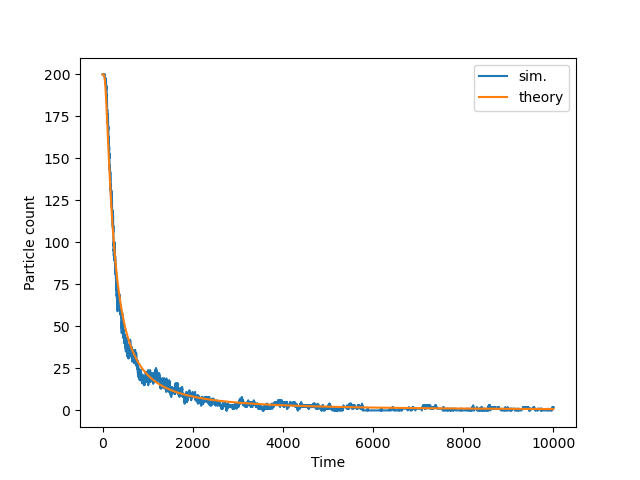

In [9]:
x_box = np.mean(subbox_definition[0])
y_box = np.mean(subbox_definition[1])
z_box = np.mean(subbox_definition[2])
volume = (subbox_definition[0][1]-subbox_definition[0][0])*(subbox_definition[1][1]-subbox_definition[1][0])*(subbox_definition[2][1]-subbox_definition[2][0])
_ = plt.close()
t = np.arange(1, len(count)+1)
_ = plt.plot(t, count, label = 'sim.')
theory = num_particles/8 * ( erf((subbox_definition[0][1]-0.5)/np.sqrt(2*t)/std_dev) - erf((subbox_definition[0][0]-0.5)/np.sqrt(2*t)/std_dev) ) \
                         * ( erf((subbox_definition[1][1]-0.5)/np.sqrt(2*t)/std_dev) - erf((subbox_definition[1][0]-0.5)/np.sqrt(2*t)/std_dev) ) \
                         * ( erf((subbox_definition[2][1]-0.5)/np.sqrt(2*t)/std_dev) - erf((subbox_definition[2][0]-0.5)/np.sqrt(2*t)/std_dev) )
_ = plt.plot(t, theory, label = 'theory')
_ = plt.legend()
_ = plt.xlabel('Time')
_ = plt.ylabel('Particle count')